# 8章 機械学習を用いたバイナリ解析～マルウェアの種類推定を例に～

## インストール

In [ ]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!git clone https://github.com/radare/radare2.git
!cd radare2 ; ./sys/install.sh
!pip install capstone r2pipe gensim adjustText

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for r2pipe: filename=r2pipe-1.9.2-py3-none-any.whl size=12224 sha256=22b1a014b55727493da106b6dc0ec873d9f9fdd3a9aee1924cc5599f113dd0b3
  Stored in directory: /root/.cache/pip/wheels/82/66/e9/51f7eca6097c57837c7e67c15aca4e397873211503626837e8
Successfully built r2pipe
2.3.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 34.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Cloning into 'radare2'...
remote: Enumerating objects: 293889, done.
remote: Counting objects: 100% (23932/23932), done.
remote: Compressing objects: 100% (1125/1125), done.
remote: Total 293889 (delta 23111), reused 23338 (delta 22783), pack-reused 269957
Receiving objects: 100% (293889/2

In [ ]:
!git clone --filter=blob:none --sparse https://github.com/editor-kagaku/Binary.git
%cd Binary
!git sparse-checkout set chapter8
%cd chapter8

## 特徴量の作成

In [ ]:
import r2pipe

def analyze_binary(path):
    r2 = r2pipe.open(path, flags=["-2"])  # バイナリファイルを開く
    r2.cmd("aaa")  # 解析コマンドを実行
    afl = r2.cmdj("aflj")  # 関数リストを取得
    return afl, r2  # 関数リストとr2オブジェクトを返す

def get_functions(afl):
    offsets = set()
    for f in afl:
        offsets.add(f.get("offset", None))  # 各関数のオフセットを取得
    return list(offsets)

def get_assembly_instructions(r2, offset):
    pdf = r2.cmdj(f'pdfj @{offset}')  # 指定されたオフセットのアセンブリ命令を取得
    instructions = []
    for d in pdf.get('ops', []):
        if d.get("disasm"):
            instructions.append(d.get("disasm"))  # アセンブリ命令をリストに追加
    return instructions

In [ ]:
import glob

# データセットを保存するリスト
data_list = []

# 実行ファイルのパスを取得
files = glob.glob('bins/*')

# 各ファイルに対して処理を実行
for file in files:
    print(f'Processing file: {file}')
    afl, r2 = analyze_binary(file)

    # 関数のオフセットを取得
    offsets = get_functions(afl)

    # 各関数のアセンブリ命令を抽出
    for offset in offsets:
        asm = get_assembly_instructions(r2, offset)
        if asm:
            data_list.append(asm)

    print(f'Finished processing file: {file}')

Processing file: bins/gcc-5__Ou__coreutils-8.25__factor
Finished processing file: bins/gcc-5__Ou__coreutils-8.25__factor
Processing file: bins/gcc-5__Ou__coreutils-8.25__numfmt
Finished processing file: bins/gcc-5__Ou__coreutils-8.25__numfmt
Processing file: bins/gcc-5__Ou__coreutils-8.25__mkfifo
Finished processing file: bins/gcc-5__Ou__coreutils-8.25__mkfifo
Processing file: bins/gcc-5__Ou__coreutils-8.25__chgrp
Finished processing file: bins/gcc-5__Ou__coreutils-8.25__chgrp
Processing file: bins/gcc-5__Ou__coreutils-8.25__ln
Finished processing file: bins/gcc-5__Ou__coreutils-8.25__ln
Processing file: bins/gcc-5__Ou__coreutils-8.25__sha512sum
Finished processing file: bins/gcc-5__Ou__coreutils-8.25__sha512sum
Processing file: bins/gcc-5__Ou__coreutils-8.25__link
Finished processing file: bins/gcc-5__Ou__coreutils-8.25__link
Processing file: bins/gcc-5__Ou__coreutils-8.25__nproc
Finished processing file: bins/gcc-5__Ou__coreutils-8.25__nproc
Processing file: bins/gcc-5__Ou__coreutils

In [ ]:
data_list

[['jmp qword [reloc.write]'],
 ['jmp qword [reloc.ferror_unlocked]'],
 ['jmp qword [reloc.__gmpz_init_set_str]'],
 ['push rbp',
  'mov rbp, rsp',
  'push rbx',
  'sub rsp, 8',
  'mov rbx, qword [obj.program_name]',
  'mov edi, str.Try__s___help_for_more_information._n',
  'call sym.imp.gettext',
  'mov rcx, rax',
  'mov rax, qword [obj.stderr]',
  'mov rdx, rbx',
  'mov rsi, rcx',
  'mov rdi, rax',
  'mov eax, 0',
  'call sym.imp.fprintf',
  'nop',
  'add rsp, 8',
  'pop rbx',
  'pop rbp',
  'ret'],
 ['push rbp',
  'mov rbp, rsp',
  'sub rsp, 0x40',
  'mov qword [rbp - 0x38], rdi',
  'mov qword [rbp - 0x40], rsi',
  'mov rax, qword [rbp - 0x38]',
  'mov rax, qword [rax + 0x10]',
  'mov qword [rbp - 0x18], rax',
  'mov rax, qword [rbp - 0x38]',
  'mov rax, qword [rax]',
  'mov qword [rbp - 0x10], rax',
  'mov rax, qword [rbp - 0x38]',
  'mov rax, qword [rax + 8]',
  'mov qword [rbp - 8], rax',
  'mov rax, qword [rbp - 0x18]',
  'sub rax, 1',
  'mov qword [rbp - 0x28], rax',
  'jmp 0x402

正規化

In [ ]:
import re

def normalize_instruction(instruction):
    # オペコードとオペランドを分割
    parts = instruction.split(maxsplit=1)
    # オペコードは最初の部分
    opcode = parts[0]
    # オペランドは残りの部分（存在する場合）
    operands = parts[1] if len(parts) > 1 else ''

    # 16進数をNに置き換え
    normalized_operands = re.sub(r'\b0x[a-fA-F0-9]+\b', 'N', operands)

    # カンマをアンダースコアに置き換え
    normalized_operands = re.sub(r'\s*,\s*', '_', normalized_operands)
    # 残ったスペースをすべて削除
    normalized_operands = re.sub(r'\s+', '', normalized_operands)

    # オペコードと正規化されたオペランドを結合
    normalized = opcode
    if normalized_operands:
        normalized += '_' + normalized_operands
    return normalized

In [ ]:
# data_listに対して正規化処理を実行
normalized_data_list = []
for asm_list in data_list:
    normalized_asm_list = [normalize_instruction(instr) for instr in asm_list]
    normalized_data_list.append(normalized_asm_list)

In [ ]:
normalized_data_list

[['jmp_qword[reloc.write]'],
 ['jmp_qword[reloc.ferror_unlocked]'],
 ['jmp_qword[reloc.__gmpz_init_set_str]'],
 ['push_rbp',
  'mov_rbp_rsp',
  'push_rbx',
  'sub_rsp_8',
  'mov_rbx_qword[obj.program_name]',
  'mov_edi_str.Try__s___help_for_more_information._n',
  'call_sym.imp.gettext',
  'mov_rcx_rax',
  'mov_rax_qword[obj.stderr]',
  'mov_rdx_rbx',
  'mov_rsi_rcx',
  'mov_rdi_rax',
  'mov_eax_0',
  'call_sym.imp.fprintf',
  'nop',
  'add_rsp_8',
  'pop_rbx',
  'pop_rbp',
  'ret'],
 ['push_rbp',
  'mov_rbp_rsp',
  'sub_rsp_N',
  'mov_qword[rbp-N]_rdi',
  'mov_qword[rbp-N]_rsi',
  'mov_rax_qword[rbp-N]',
  'mov_rax_qword[rax+N]',
  'mov_qword[rbp-N]_rax',
  'mov_rax_qword[rbp-N]',
  'mov_rax_qword[rax]',
  'mov_qword[rbp-N]_rax',
  'mov_rax_qword[rbp-N]',
  'mov_rax_qword[rax+8]',
  'mov_qword[rbp-8]_rax',
  'mov_rax_qword[rbp-N]',
  'sub_rax_1',
  'mov_qword[rbp-N]_rax',
  'jmp_N',
  'mov_rax_qword[rbp-N]',
  'shl_rax_4',
  'mov_rdx_rax',
  'mov_rax_qword[rbp-N]',
  'add_rdx_rax',
  

In [ ]:
from gensim.models import Word2Vec
# Word2Vecモデルのトレーニング
print('Training Word2Vec model...')
model = Word2Vec(normalized_data_list, vector_size=100, window=2, min_count=1, workers=4)
print('Training complete.')

# モデルの保存
model.save('assembly_word2vec.model')

Training Word2Vec model...
Training complete.


In [ ]:
# モデルの読み込み
model = Word2Vec.load('assembly_word2vec.model')

# アセンブリ命令をベクトル化する関数
def vectorize_assembly_instruction(instruction):
    if instruction in model.wv:
        return model.wv[instruction]
    else:
        print(f'Instruction {instruction} not found in vocabulary.')
        return None

# テスト用のアセンブリ命令
test_instructions = ['je_N', 'jb_N', 'cmp_ax_N']

# 各アセンブリ命令をベクトル化
for instruction in test_instructions:
    vector = vectorize_assembly_instruction(instruction)
    if vector is not None:
        print(f'Vector for instruction {instruction}: {vector}')

Vector for instruction je_N: [-0.61822313 -0.10327474 -1.4051253  -0.4493344   0.4258791   1.4436992
 -0.72432667 -0.5288697  -0.11093639  1.2681277   0.30305815  0.95712376
 -1.6666346   0.08679131 -0.6480609  -1.8202763   0.7303402   0.9457737
 -0.19333078  0.4766793  -1.5802193  -1.204298    0.755792   -1.3603168
  0.65703624 -1.1552713   1.7552187   0.43234614 -0.44460702  1.2021214
  0.72990644 -1.5277544  -0.32634756 -0.23315886  0.05090514 -1.4048725
 -1.0546736   0.17075798  0.2511613   0.25937626 -1.5604602   0.38018525
 -0.7143402   0.75019723  0.4038095   0.4676168   1.1352801  -0.5921617
 -0.5457779   0.12849131  0.66213655 -0.23227553 -0.9806559   0.47107086
 -1.4791886  -1.3792185   0.35055485 -0.9850005  -1.061521   -1.7454449
  1.358009   -0.16463652 -0.596452   -0.46781516 -0.007643    1.100235
  1.6738673   0.40439656 -0.18906596  0.46172506 -0.23344639  1.5044503
  0.65707564  0.26511192 -1.2423376   0.8582834   1.0841005   0.13231772
  0.22821344 -0.11090463 -0.5267

t-SNE

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

# アセンブリ命令のベクトルを取得
vectors = [model.wv[word] for word in model.wv.index_to_key]

# リストをNumPy配列に変換
vectors_np = np.array(vectors)

# t-SNEによる次元削減
tsne = TSNE(n_components=2, perplexity=10, learning_rate=300, n_iter=1000, random_state=22)
vectors_2d = tsne.fit_transform(vectors_np)


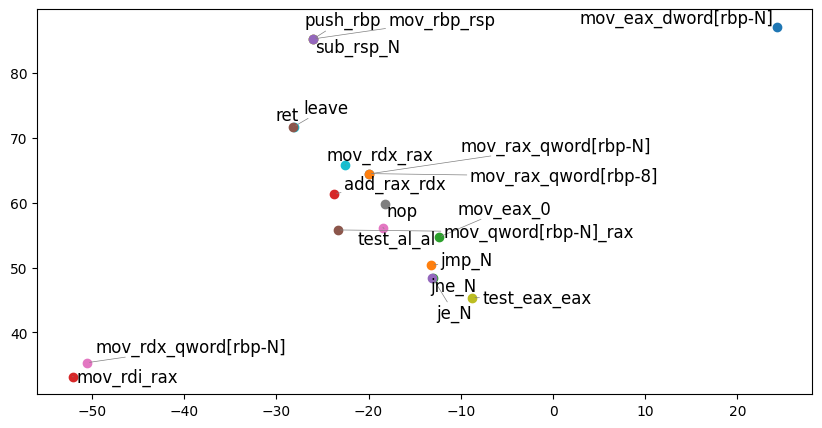

In [ ]:
from adjustText import adjust_text

# 可視化する命令の数を指定（例：最初の20個）
num_to_visualize = 20
vectors_2d_subset = vectors_2d[:num_to_visualize]
words_subset = model.wv.index_to_key[:num_to_visualize]

# 可視化
plt.figure(figsize=(10, 5))
texts = []
for i, word in enumerate(words_subset):
    plt.scatter(vectors_2d_subset[i, 0], vectors_2d_subset[i, 1])
    texts.append(plt.text(vectors_2d_subset[i, 0], vectors_2d_subset[i, 1], word, fontsize=12))

# ラベルが重ならないように調整
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

plt.show()

## Graph Neural Networkを使用したマルウェア分類

In [ ]:
import pickle
import os
import glob

# データセットが保存されているディレクトリ
base_path = './malware_category_dataset'

# フォルダ内のすべてのpklファイルを検索
pkl_files = glob.glob(os.path.join(base_path, '*.pkl'))

# データセットを読み込んで結合
dataset = []

for pkl_file in pkl_files:
    with open(pkl_file, 'rb') as f:
        split_data = pickle.load(f)
        dataset.extend(split_data)

In [ ]:
dataset[:5]

[Data(x=[2, 100], edge_index=[2, 0], y=[1], num_nodes=2, funcname=[2]),
 Data(x=[56, 100], edge_index=[2, 49], y=[1], num_nodes=56, funcname=[56]),
 Data(x=[2, 100], edge_index=[2, 0], y=[1], num_nodes=2, funcname=[2]),
 Data(x=[667, 100], edge_index=[2, 1472], y=[1], num_nodes=667, funcname=[667]),
 Data(x=[651, 100], edge_index=[2, 1139], y=[1], num_nodes=651, funcname=[651])]

In [ ]:
from collections import Counter
from torch_geometric.data import Data

# ラベル名のリスト
label_names = ['backdoor', 'downloader', 'dropper', 'ransomware', 'trojan', 'worm']

# ラベルをカウントする関数
def count_labels(dataset):
    labels = [data.y.item() for data in dataset]
    label_counts = Counter(labels)
    return label_counts

# ラベルのカウント
label_counts = count_labels(dataset)

# ラベルのカウント結果を表示
print('Label counts:')
for label_id in range(len(label_names)):
    count = label_counts[label_id] if label_id in label_counts else 0
    print(f'{label_names[label_id].ljust(12)} ({label_id}): {count} samples')

Label counts:
backdoor     (0): 538 samples
downloader   (1): 870 samples
dropper      (2): 357 samples
ransomware   (3): 152 samples
trojan       (4): 693 samples
worm         (5): 622 samples


In [ ]:
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

# データセットを8:2に分割
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, LeakyReLU
from torch_geometric.nn import GATConv
from custom_layers import Set2Set, dropout_edge  # Set2Setクラスとdropout_edge関数をインポート
from typing import Optional, Tuple

# FCGATモデル定義
class FCGAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        """
        モデルの初期化
        :param hidden_channels: 隠れ層の次元
        :param num_features: 特徴量の次元
        :param num_classes: 出力クラスの数
        """
        super(FCGAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, add_self_loops=False, heads=3)
        self.conv2 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)
        self.lin1 = Linear(num_features, hidden_channels*3, bias=False)
        self.lin2 = Linear(hidden_channels*2, hidden_channels)
        self.lin3 = Linear(hidden_channels*2*3, num_classes)
        self.leakyrelu = LeakyReLU()
        self.set2set = Set2Set(hidden_channels*3, 4)

    def forward(self, x, edge_index, x_init, batch):
        edge_index_dp, _ = dropout_edge(edge_index)
        x = self.conv1(x, edge_index_dp)
        x = self.leakyrelu(x)
        x_tmp = self.lin1(x_init)
        x += x_tmp
        x = self.leakyrelu(x)
        x, a_list = self.set2set(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)

        return x, a_list

# デバイスの設定（GPUを優先的に使用）
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# モデルの初期化とデバイスへの移動
model = FCGAT(hidden_channels=64, num_features=100, num_classes=6).to(device)
print(model)

FCGAT(
  (conv1): GATConv(100, 64, heads=3)
  (conv2): GATConv(64, 64, heads=1)
  (lin1): Linear(in_features=100, out_features=192, bias=False)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=384, out_features=6, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (set2set): Set2Set(192, 384)
)


In [ ]:
# train関数
def train(loader, model, optimizer, criterion, device):
    model.train()  # モデルを訓練モードに設定
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # 勾配を初期化
        data = data.to(device)  # データをGPUに転送
        out, _ = model(data.x, data.edge_index, data.x, data.batch)
        loss = criterion(out, data.y)  # 損失を計算
        loss.backward()  # 勾配を計算
        optimizer.step()  # モデルのパラメータを更新
        total_loss += loss.item()  # 合計損失を更新
    return total_loss / len(loader)  # 平均損失を返す

# test関数
def test(loader, model, device):
    model.eval()  # モデルを評価モードに設定
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():  # 評価モードで勾配を計算しない
        for data in loader:
            data = data.to(device)  # データをGPUに転送
            out, _ = model(data.x, data.edge_index, data.x, data.batch)
            pred = out.argmax(dim=1)  # 予測結果を取得
            correct += int((pred == data.y).sum())  # 正解数をカウント
            all_preds.extend(pred.cpu().numpy())  # 予測結果をリストに追加
            all_labels.extend(data.y.cpu().numpy())  # 正解ラベルをリストに追加
    return correct / len(loader.dataset), all_preds, all_labels

# trainとtestを実行する関数
def run_training(train_loader, test_loader, model, optimizer, criterion, device, epochs=10):
    history = np.zeros((0, 3))  # 訓練履歴を保存する配列
    start_time = time.time()
    for epoch in range(1, epochs + 1):
        train_loss = train(train_loader, model, optimizer, criterion, device)  # 訓練を実行
        train_acc, _, _ = test(train_loader, model, device)  # 訓練データで評価
        test_acc, test_preds, test_labels = test(test_loader, model, device)  # テストデータで評価
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        history = np.vstack((history, [epoch, train_acc, test_acc]))
    end_time = time.time()
    print('Training Time: ', end_time - start_time)
    return history, test_labels, test_preds


In [ ]:
import torch.nn as nn
import torch.optim as optim

# ハイパーパラメータとセットアップ
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
epochs=100

In [ ]:
# 学習の実行
history, test_labels, test_preds = run_training(train_loader, test_loader, model, optimizer, criterion, device, epochs)

Epoch: 001, Train Loss: 1.5842, Train Acc: 0.4681, Test Acc: 0.4451
Epoch: 002, Train Loss: 1.2116, Train Acc: 0.7056, Test Acc: 0.6940
Epoch: 003, Train Loss: 0.9148, Train Acc: 0.7524, Test Acc: 0.7419
Epoch: 004, Train Loss: 0.7712, Train Acc: 0.8031, Test Acc: 0.7975
Epoch: 005, Train Loss: 0.6316, Train Acc: 0.8193, Test Acc: 0.7960
Epoch: 006, Train Loss: 0.5915, Train Acc: 0.8259, Test Acc: 0.8099
Epoch: 007, Train Loss: 0.5805, Train Acc: 0.8104, Test Acc: 0.8053
Epoch: 008, Train Loss: 0.5507, Train Acc: 0.8515, Test Acc: 0.8393
Epoch: 009, Train Loss: 0.4914, Train Acc: 0.8499, Test Acc: 0.8300
Epoch: 010, Train Loss: 0.4521, Train Acc: 0.8638, Test Acc: 0.8408
Epoch: 011, Train Loss: 0.4297, Train Acc: 0.8712, Test Acc: 0.8624
Epoch: 012, Train Loss: 0.4077, Train Acc: 0.8793, Test Acc: 0.8594
Epoch: 013, Train Loss: 0.3562, Train Acc: 0.8956, Test Acc: 0.8764
Epoch: 014, Train Loss: 0.3488, Train Acc: 0.8940, Test Acc: 0.8717
Epoch: 015, Train Loss: 0.3714, Train Acc: 0.895

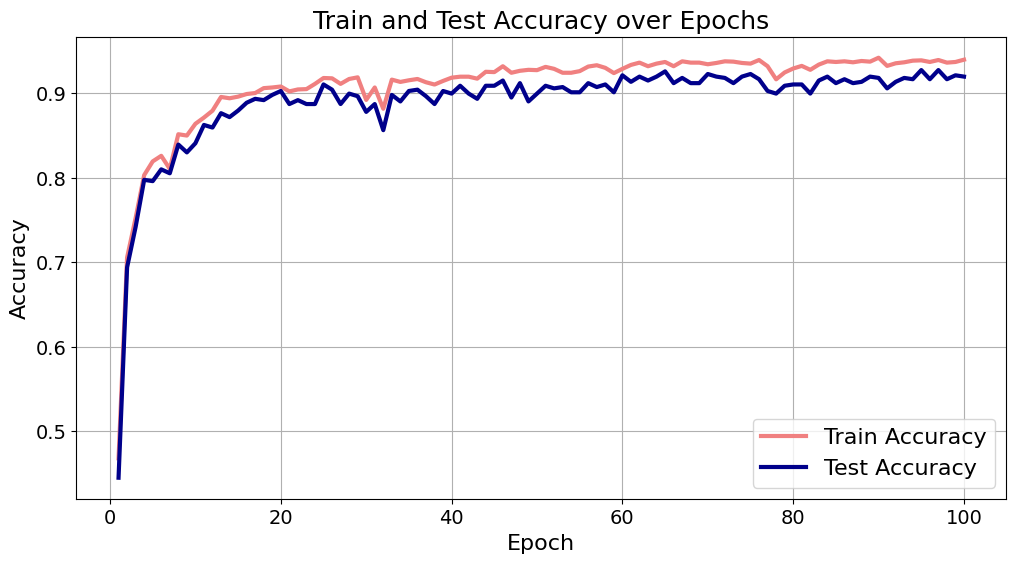

In [ ]:
# 学習曲線をプロット
plt.figure(figsize=(12, 6))
plt.plot(history[:, 0], history[:, 1], label='Train Accuracy', color='lightcoral', linewidth=3)
plt.plot(history[:, 0], history[:, 2], label='Test Accuracy', color='darkblue', linewidth=3)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=16)
plt.title('Train and Test Accuracy over Epochs', fontsize=18)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

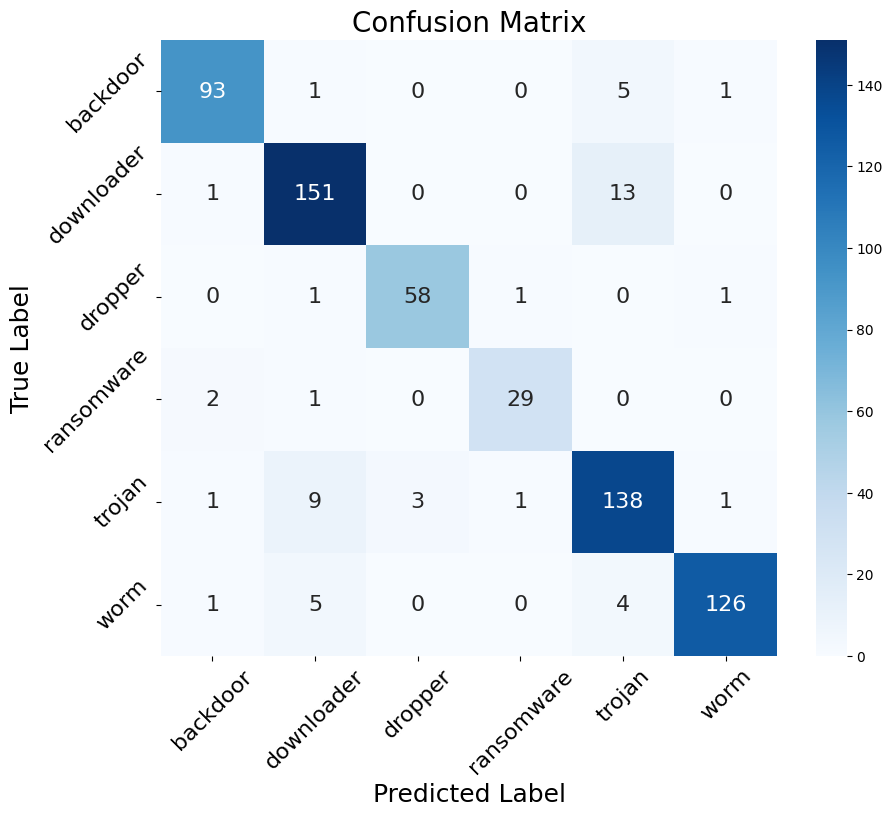

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 混同行列を生成
cm = confusion_matrix(test_labels, test_preds)

# ラベルを設定
labels = ['backdoor', 'downloader', 'dropper', 'ransomware', 'trojan', 'worm']

# 混同行列を表示
plt.figure(figsize=(10, 8))
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 16},
            xticklabels=labels, yticklabels=labels)

# フォントサイズを設定
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16, rotation=45)
plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.title('Confusion Matrix', fontsize=20)

plt.show()